# Getting started with the EB-NeRD

In [1]:
import polars as pl
from matplotlib_venn import venn3

from ebrec.utils._constants import (
    DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
)
from exputils.const import DATA_DIR

## 1. Load dataset

In [2]:
data_dirs = {
    "train": DATA_DIR / "ebnerd" / "train",
    "validation": DATA_DIR / "ebnerd" / "validation",
    "test": DATA_DIR / "ebnerd" / "ebnerd_testset" / "test",
}

### 1.1. Behaviors

| # | Column | Context | Example |
|---|--------|---------|---------|
| 1 | impression_id | The ID of an impression. | 153 |
| 2 | user_id | The anonymized user ID. | 44038 |
| 3 | article_id | (※ Train / Valid only) The unique ID of a news article. An empty field means the impression is from the front page. | 9650148 |
| 4 | session_id | A unique identifier for a user's browsing session. | 1153 |
| 5 | article_ids_inview | List of inview news articles in the impression (news articles that was registered as seen by the user). The orders of the IDs have been shuffled. | [9649538, 9649689, … 9649569] |
| 6 | article_ids_clicked | (※ Train / Valid only) List of news articles clicked in the impression. | [9649689] |
| 7 | impression_time | The impression timestamp. The format is "YYYY/MM/DD HH:MM:SS". | 2023-02-25 06:41:40 |
| 8 | read_time | The amount of seconds a user spend on a given page. | 14.0 |
| 9 | scroll_percentage | The percentage of an article that a user scrolls through, indicating how much of the content was potentially viewed. | 100.0 |
| 10 | device_type | The type of device used to access the content, such as desktop (1) mobile (2), tablet (3), or unknown (0). | 1 |
| 11 | is_sso_user | Indicates whether a user is logged in through Single Sign-On (SSO) authentication. | True |
| 13 | is_subscriber | The user's subscription status, indicating whether they are a paid subscriber. | True |
| 14 | gender | The gender of the user, either Male (0) or Female (1), as specified in their profile. | null |
| 15 | postcode | The user's postcode, aggregated at the district level as specified in their profile, with metropolitan (0), rural district (1), municipality (2), provincial (3), big city (4). | 2 |
| 16 | age | The age of the user, as specified in their profile, categorized into bins of 10 years (e.g., 20-29, 30-39 etc.). | 50 |
| 17 | next_read_time | (※ Train / Valid only) The time a user spends on the next clicked article, i.e., the article in Clicked Article IDs. | 8.0 |
| 18 | next_scroll_percentage | (※ Train / Valid only) The scroll percentage for a user's next article interaction, i.e., the article in Clicked Article IDs. | 41.0 |

In [3]:
df_behaviors = pl.concat(
    [
        pl.scan_parquet(data_dir / "behaviors.parquet").with_columns(
            pl.lit(data_split).alias("data_split"),
        )
        for data_split, data_dir in data_dirs.items()
    ],
    how="diagonal",
)
df_behaviors.collect()

impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage,data_split,is_beyond_accuracy
u32,i32,datetime[μs],f32,f32,i8,list[i32],list[i32],u32,bool,i8,i8,i8,bool,u32,f32,f32,str,bool
47727,null,2023-05-21 21:35:07,20.0,null,1,"[9482380, 9775183, … 9538375]",[9775183],18293,false,null,null,null,false,265,34.0,100.0,"""train""",null
47731,null,2023-05-21 21:32:33,13.0,null,1,"[9774557, 9774516, … 9759966]",[9759966],18293,false,null,null,null,false,265,45.0,100.0,"""train""",null
47736,null,2023-05-21 21:33:32,17.0,null,1,"[9759966, 9774557, … 9775323]",[9774652],18293,false,null,null,null,false,265,78.0,100.0,"""train""",null
47737,null,2023-05-21 21:38:17,27.0,null,1,"[9774580, 9775131, … 9774899]",[9775184],18293,false,null,null,null,false,265,6.0,52.0,"""train""",null
47740,null,2023-05-21 21:36:02,48.0,null,1,"[9774826, 9775171, … 9774648]",[9774648],18293,false,null,null,null,false,265,32.0,100.0,"""train""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,null,2023-06-01 07:00:01,0.0,null,0,"[9793163, 9793069, … 9789545]",null,1589163,false,null,null,null,false,0,null,null,"""test""",true
0,null,2023-06-01 07:00:01,0.0,null,0,"[9793163, 9793069, … 9789545]",null,1699456,false,null,null,null,false,0,null,null,"""test""",true
0,null,2023-06-01 07:00:01,0.0,null,0,"[9793163, 9793069, … 9789545]",null,635479,false,null,null,null,false,0,null,null,"""test""",true


### 1.2. History

| # | Column | Context | Example |
|---|--------|---------|---------|
| 1 | user_id | The anonymized user ID. | 44038 |
| 2 | article_id_fixed | The articles clicked by the user. | [9618533, … 9646154] |
| 3 | impression_time_fixed | The timestamps of when the articles were clicked. The format is "YYYY/MM/DD HH:MM:SS". | [2023-02-02 16:37:42, … 2023-02-22 18:28:38] |
| 4 | read_time_fixed | The read times of the clicked articles. | [425.0, … 12.0] |
| 5 | scroll_percentage_fixed | The scroll percentages of the clicked articles. | [null, … 100.0] |

In [4]:
df_history = pl.concat(
    [
        pl.scan_parquet(data_dir / "history.parquet").with_columns(
            pl.lit(data_split).alias("data_split"),
        )
        for data_split, data_dir in data_dirs.items()
    ],
)
df_history.collect()

user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed,data_split
u32,list[datetime[μs]],list[f32],list[i32],list[f32],str
10029,"[2023-04-28 06:16:57, 2023-04-28 06:17:31, … 2023-05-18 06:59:50]","[23.0, 69.0, … null]","[9735579, 9739888, … 9770541]","[28.0, 24.0, … 0.0]","""train"""
10033,"[2023-04-27 11:11:32, 2023-04-27 11:12:56, … 2023-05-17 20:22:42]","[33.0, 41.0, … 29.0]","[9738139, 9738263, … 9769404]","[2.0, 2.0, … 1.0]","""train"""
10034,"[2023-04-30 09:46:57, 2023-04-30 09:47:33, … 2023-05-16 08:40:52]","[null, 88.0, … 100.0]","[9742693, 9742686, … 9767363]","[21.0, 103.0, … 9.0]","""train"""
10041,"[2023-04-27 15:15:28, 2023-04-27 15:16:30, … 2023-05-17 14:54:05]","[78.0, 41.0, … 57.0]","[9739035, 9738303, … 9757869]","[12.0, 11.0, … 22.0]","""train"""
10103,"[2023-04-27 15:37:35, 2023-04-27 15:38:37, … 2023-05-18 04:52:09]","[100.0, null, … 63.0]","[9739035, 9739164, … 9769433]","[45.0, 8.0, … 24.0]","""train"""
…,…,…,…,…,…
1522546,"[2023-05-27 08:21:44, 2023-05-27 08:22:48, … 2023-05-27 08:25:15]","[100.0, 32.0, … 39.0]","[9782645, 9782929, … 9781991]","[64.0, 10.0, … 2.0]","""test"""
599984,"[2023-05-13 23:04:56, 2023-05-13 23:07:42, … 2023-05-13 23:11:41]","[100.0, 56.0, … 69.0]","[9759355, 9764086, … 9763857]","[166.0, 8.0, … 12.0]","""test"""
1086197,"[2023-05-14 21:11:26, 2023-05-14 21:15:41, … 2023-05-14 21:20:14]","[null, 42.0, … 74.0]","[9740843, 9765450, … 9765175]","[249.0, 5.0, … 10.0]","""test"""


### 1.3. Articles

| # | Column | Context | Example |
|---|--------|---------|---------|
| 1 | article_id | The unique ID of a news article. | 8987932 |
| 2 | title | The article's Danish title. | Se billederne: Zlatans paradis til salg |
| 3 | subtitle | The article's Danish subtitle/abstract. | Zlatan Ibrahimovic har sat sin skihytte i Åre til salg, men prisen skal nok afskrække en del. (...) |
| 4 | body | The article's full Danish text body. | Drømmer du om en eksklusiv skihytte i Sverige? Så har Zlatan Ibrahimovic et eksklusivt tilbud til dig (...) |
| 5 | category | The category ID. | 142 |
| 6 | category_str | The category as a string. | sport |
| 7 | subcategory | The subcategory IDs. | [196, 271] |
| 8 | premium | Whether the content is behind a paywall. | False |
| 9 | published_time | The time the article was published. The format is "YYYY/MM/DD HH:MM:SS". | 2021-11-15 03:56:56 |
| 10 | last_modified_time | The timestamp for the last modification of the article, e.g., updates as the story evolves or spelling corrections. The format is "YYYY/MM/DD HH:MM:SS". | 2023-06-29 06:38:41 |
| 11 | image_ids | The image IDs used in the article. | [8988118] |
| 12 | article_type | The type of article, such as a feature, gallery, video, or live blog. | article_default |
| 13 | url | The article's URL. | https://ekstrabladet.dk/.../8987932 |
| 14 | ner_clusters | The tags retrieved from a proprietary named-entity-recognition model at Ekstra Bladet are based on the concatenated title, abstract, and body. | ['Aftonbladet', 'Åre', 'Bjurfors', 'Cecilia Edfeldt Jigstedt', 'Helena', 'Sverige', 'Zlatan Ibrahimovic'] |
| 15 | entity_groups | The tags retrieved from a proprietary entity-recognition model at Ekstra Bladet are based on the concatenated title, abstract, and body. | ['ORG', 'LOC', 'ORG', 'PER', 'PER', 'LOC', 'PER'] |
| 16 | topics | The tags retrieved from a proprietary topic-recognition model at Ekstra Bladet are based on the concatenated title, abstract, and body. | [] |
| 17 | total_inviews | The total number of times an article has been inview (registered as seen) by users within the first 7 days after it was published. This feature only applies to articles that were published after February 16, 2023. | null |
| 18 | total_pageviews | The total number of times an article has been clicked by users within the first 7 days after it was published. This feature only applies to articles that were published after February 16, 2023. | null |
| 19 | total_read_time | The accumulated read time of an article within the first 7 days after it was published. This feature only applies to articles that were published after February 16, 2023. | null |
| 20 | sentiment_score | The sentiment score from a proprietary sentiment model at Ekstra Bladet is based on the concatenated title and abstract. | 0.5299 |
| 21 | sentiment_label | The assigned sentiment label from a proprietary sentiment model at Ekstra Bladet is based on the concatenated title and abstract. The labels are positive, neutral, and negative. | Neutral |

In [5]:
df_articles = pl.scan_parquet(DATA_DIR / "ebnerd" / "articles.parquet")
display(df_articles.collect())

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3000022,"""Hanks beskyldt…","""Tom Hanks har …",2023-06-29 06:20:32,false,"""Tom Hanks skul…",2006-09-20 09:24:18,[3518381],"""article_defaul…","""https://ekstra…","[""David Gardner""]","[""PER""]","[""Kriminalitet"", ""Kendt"", … ""Litteratur""]",414,[432],"""underholdning""",null,null,null,0.9911,"""Negative"""
3000063,"""Bostrups aske …","""Studieværten b…",2023-06-29 06:20:32,false,"""Strålende sens…",2006-09-24 07:45:30,"[3170935, 3170939]","""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Personlig begivenhed""]",118,[133],"""nyheder""",null,null,null,0.5155,"""Neutral"""
3000613,"""Jesper Olsen r…","""Den tidligere …",2023-06-29 06:20:33,false,"""Jesper Olsen, …",2006-05-09 11:29:00,[3164998],"""article_defaul…","""https://ekstra…","[""Frankrig"", ""Jesper Olsen"", … ""Jesper Olsen""]","[""LOC"", ""PER"", … ""PER""]","[""Kendt"", ""Sport"", … ""Sygdom og behandling""]",142,"[196, 271]","""sport""",null,null,null,0.9876,"""Negative"""
3000700,"""Madonna topløs…","""47-årige Madon…",2023-06-29 06:20:33,false,"""Skal du have s…",2006-05-04 11:03:12,[3172046],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Livsstil"", ""Underholdning""]",414,[432],"""underholdning""",null,null,null,0.8786,"""Neutral"""
3000840,"""Otto Brandenbu…","""Sangeren og sk…",2023-06-29 06:20:33,false,"""'Og lidt for S…",2007-03-01 18:34:00,[3914446],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Musik og lyd""]",118,[133],"""nyheder""",null,null,null,0.9468,"""Negative"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9803505,"""Flyvende Anton…","""Verdens nummer…",2023-06-29 06:49:26,false,"""Anders Antonse…",2023-06-08 05:54:06,[9803516],"""article_defaul…","""https://ekstra…","[""Alexandra Bøje"", ""All England"", … ""Taiwan""]","[""PER"", ""PROD"", … ""LOC""]","[""Kendt"", ""Begivenhed"", … ""Sportsbegivenhed""]",142,"[327, 330]","""sport""",13320,959,55691.0,0.8884,"""Positive"""
9803510,"""Nedschroef Lan…","""Hos Nedschroef…",2023-06-29 06:49:26,false,"""Et udbytte på …",2023-06-08 05:48:51,[9803509],"""article_defaul…","""https://ekstra…","[""Bytoften"", ""Erhvervsstyrelsen"", … ""Plettenberg Gmbh""]","[""LOC"", ""ORG"", … ""PER""]","[""Erhverv"", ""Privat virksomhed"", ""Økonomi""]",2889,"[2890, 2900]","""auto""",12,1,25.0,0.8723,"""Negative"""
9803525,"""Dansk skuespil…","""Julie R. Ølgaa…",2023-06-29 06:49:26,false,"""Mens hun lå sø…",2023-06-08 06:45:46,"[9803518, 9803519, … 9803524]","""article_defaul…","""https://ekstra…","[""Cooper"", ""Englemageren"", … ""Svangerskabsforgiftning""]","[""PER"", ""PROD"", … ""MISC""]","[""Kendt"", ""Livsstil"", … ""Sygdom og behandling""]",414,[425],"""underholdning""",315391,50361,2.550671e6,0.7737,"""Negative"""


## 2. Statistics

### 2.1. user_ids venn diagram

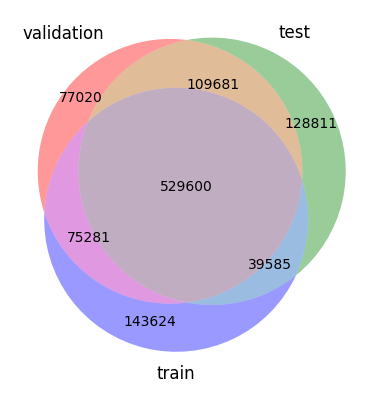

In [6]:
user_ids = {
    data_split: set(user_ids)
    for data_split, user_ids in df_history.group_by("data_split")
    .agg(pl.col("user_id"))
    .collect()
    .iter_rows()
}
venn3(subsets=list(user_ids.values()), set_labels=tuple(user_ids.keys()))

### 2.2. History / Behaviors statistics with data-split

In [11]:
df_history_summary = (
    df_history.with_columns(
        (
            pl.col(DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL)
            .list.eval(pl.element().min())
            .explode()
            .name.suffix("_min")
        ),
        (
            pl.col(DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL)
            .list.eval(pl.element().max())
            .explode()
            .name.suffix("_max")
        ),
    )
    .group_by("data_split")
    .agg(
        pl.col(f"{DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL}_min").min(),
        pl.col(f"{DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL}_max").max(),
        pl.len().alias("count"),
    )
    .sort(f"{DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL}_min")
)
df_behaviors_summary = (
    df_behaviors.group_by("data_split")
    .agg(
        pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).min().name.suffix("_min"),
        pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).max().name.suffix("_max"),
        pl.col("read_time").mean().name.suffix("_mean"),
        pl.col("read_time").max().name.suffix("_max"),
        pl.col("scroll_percentage").mean().name.suffix("_mean"),
        pl.col("scroll_percentage").max().name.suffix("_max"),
        pl.len().alias("count"),
    )
    .sort(f"{DEFAULT_IMPRESSION_TIMESTAMP_COL}_min")
)
print(f"History: {df_history_summary.collect()}")
print(f"Behaviors: {df_behaviors_summary.collect()}")

History: shape: (3, 4)
┌────────────┬───────────────────────────┬───────────────────────────┬────────┐
│ data_split ┆ impression_time_fixed_min ┆ impression_time_fixed_max ┆ count  │
│ ---        ┆ ---                       ┆ ---                       ┆ ---    │
│ str        ┆ datetime[μs]              ┆ datetime[μs]              ┆ u32    │
╞════════════╪═══════════════════════════╪═══════════════════════════╪════════╡
│ train      ┆ 2023-04-27 07:00:00       ┆ 2023-05-18 06:59:59       ┆ 788090 │
│ validation ┆ 2023-05-04 07:00:00       ┆ 2023-05-25 06:59:59       ┆ 791582 │
│ test       ┆ 2023-05-11 07:00:00       ┆ 2023-06-01 06:59:59       ┆ 807677 │
└────────────┴───────────────────────────┴───────────────────────────┴────────┘
Behaviors: shape: (3, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬──────────┐
│ data_split ┆ impression ┆ impression ┆ read_time_ ┆ read_time ┆ scroll_pe ┆ scroll_pe ┆ count    │
│ ---        ┆ _time_min  ┆ _t

### 2.3. Behavior statistics with num_articles 

In [8]:
df_behaviors_clicked_summary = (
    df_behaviors.with_columns(
        pl.col("article_ids_clicked").list.len().alias("num_articles"),
    )
    .group_by("data_split", "num_articles")
    .len()
    .collect()
    .pivot(index="num_articles", columns="data_split", values="len")
    .select("num_articles", "train", "validation", "test")
    .sort("num_articles")
)
df_behaviors_inview_summary = (
    df_behaviors.with_columns(
        pl.col("article_ids_inview").list.len().alias("num_articles"),
    )
    .group_by("data_split", "num_articles")
    .len()
    .collect()
    .pivot(index="num_articles", columns="data_split", values="len")
    .select("num_articles", "train", "validation", "test")
    .sort("num_articles")
)
df_history_summary = (
    df_history.with_columns(
        pl.col("article_id_fixed").list.len().alias("num_articles"),
    )
    .group_by("data_split", "num_articles")
    .len()
    .collect()
    .pivot(index="num_articles", columns="data_split", values="len")
    .select("num_articles", "train", "validation", "test")
    .sort("num_articles")
)
print(f"Clicked: {df_behaviors_clicked_summary}")
print(f"Inview: {df_behaviors_inview_summary}")
print(f"History: {df_history_summary}")

Clicked: shape: (13, 4)
┌──────────────┬──────────┬────────────┬──────────┐
│ num_articles ┆ train    ┆ validation ┆ test     │
│ ---          ┆ ---      ┆ ---        ┆ ---      │
│ u32          ┆ u32      ┆ u32        ┆ u32      │
╞══════════════╪══════════╪════════════╪══════════╡
│ 0            ┆ null     ┆ null       ┆ 13536710 │
│ 1            ┆ 12004156 ┆ 12494779   ┆ null     │
│ 2            ┆ 53705    ┆ 65626      ┆ null     │
│ 3            ┆ 3566     ┆ 3500       ┆ null     │
│ 4            ┆ 1258     ┆ 1083       ┆ null     │
│ …            ┆ …        ┆ …          ┆ …        │
│ 8            ┆ 28       ┆ 135        ┆ null     │
│ 9            ┆ 11       ┆ 68         ┆ null     │
│ 10           ┆ 2        ┆ 21         ┆ null     │
│ 11           ┆ null     ┆ 6          ┆ null     │
│ 12           ┆ null     ┆ 2          ┆ null     │
└──────────────┴──────────┴────────────┴──────────┘
Inview: shape: (97, 4)
┌──────────────┬─────────┬────────────┬─────────┐
│ num_articles ┆ tr

### 2.4. Behavior statistics with user_id

In [9]:
(
    df_behaviors.group_by(["data_split", "user_id"])
    .len()
    .group_by("data_split")
    .agg(
        pl.col("len").max().alias("max"),
        pl.col("len").median().alias("median"),
        pl.col("len").min().alias("min"),
        pl.len().alias("count"),
    )
    .collect()
)

data_split,max,median,min,count
str,u32,f64,u32,u32
"""validation""",276,9.0,1,791582
"""train""",250,9.0,1,788090
"""test""",300,10.0,1,807677
